In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai.text.all import *
from reformer_fastai.reformer import LSHLM
from reformer_fastai.data import TwinSequence, MaskTargCallback
from reformer_fastai.metrics import MaskedAccuracy
from reformer_fastai.optimizers import adafactor
from reformer_fastai.tracking import WandbCallback
import wandb

In [ ]:
#hide
#skip
torch.cuda.set_device(0)

In [ ]:
#hide
#all_slow

# Minimal training example

## initialise wandb

In [ ]:
WANDB_NAME = 'lshlm_synt_test'
GROUP = 'TEST'
NOTES = 'Syntethic task testing'
CONFIG = {}
TAGS =['lsh', 'lm','test','synthetic-task']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


## get data

In [ ]:
bs, sl = 32,64
train_sz, valid_sz = 500, 100
def get_dataloaders(bs:int=32, sl:int=64, train_sz:int=500, valid_sz:int=100):
    dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=bs, shuffle=False, device='cuda')
    return dls
dls = get_dataloaders(bs, sl, train_sz, valid_sz)

## get model

In [ ]:
bucket_size = 32
n_hashes=4
use_lsh=True
model = LSHLM(vocab_sz=128, d_model=256, n_layers=1, n_heads=4, 
              max_seq_len=sl,bucket_size=bucket_size, n_hashes=n_hashes, 
              causal=True, use_lsh=use_lsh)

## train

In [ ]:
n_epochs = 1
lr = 1e-3
learn = Learner(dls, model, opt_func=adafactor, 
                loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=MaskedAccuracy(), 
                cbs=[MaskTargCallback(), WandbCallback(log_model=False, log_preds=False)]).to_fp16()
learn.fit(n_epochs, lr)

epoch,train_loss,valid_loss,masked_accuracy,time
0,5.512778,4.799141,0.038125,00:03


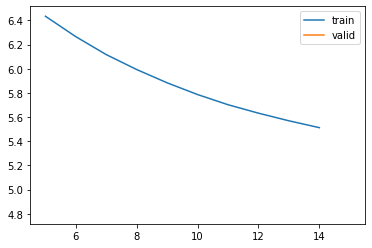

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save(f'Synt_full-run_n_hashes-{n_hashes}_use-lsh-{use_lsh}')

Path('models/Synt_full-run_n_hashes-4_use-lsh-True.pth')